# Question 2: Upscaling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal
from skimage import color

%matplotlib inline

# Upscaling by nearest neighbour + blurring
Turns each pixel into a 3x3 superpixel in a bigger image, then blurs the big image. Blurring applied using functions from assignment 1.

In [2]:
# Helper functions (from assignment 1), 

# convolution, covlolution for RGB image, Gaussian filter



def convolution2D(F, I):
    '''
    Returns F∗I, the convolution of image I with filter F such that the result is the same size as the input image.
    
    I: a 2D matrix of integers
    F: a 2D square matrix of integers, with odd dimension
    
    result: F∗I
    '''
    
    # Zero-pad I based on the size of F
    k = np.shape(F)[0]
    padWidth = int((k-1)/2)   
    I = np.pad(I, ((padWidth, padWidth), (padWidth, padWidth)), 'constant')
    
    # initialize matrix for the result of convolution
    result = np.zeros(np.shape(I))
    
    # Flip the filter in both dimensions (so that you can just apply correlation)
    F = np.flipud(F)
    F = np.fliplr(F)
    
    # Convert filter to 1D array to use vector form of correlation formula
    F = np.ravel(F)
    
    # Perform correlation
    for i in range(padWidth, I.shape[0]-padWidth):
        for j in range(padWidth, I.shape[1]-padWidth):
            
            # Apply filter to I(i,j) by converting the sub-matrix centered at I(i,j),
            # and has the same dimensions as the filter, to a 1D array
            subMatrix = I[i-padWidth:i+padWidth+1, j-padWidth:j+padWidth+1]
            subMatrix = np.ravel(subMatrix)
            
            result[i,j] = np.dot(F, subMatrix)
            
    
    # Remove the padding
    result = result[padWidth:result.shape[0]-padWidth, padWidth:result.shape[1]-padWidth]
    return result




def convolutionRGB(F, I):
    '''
    Returns F∗I, the convolution of an RGB image I with filter F such that the result is the same size as the input image.
    
    I: a 3D matrix of integers (consists of three 2D matrices, one for each channel of RGB)
    F: a 3D square matrix of integers, with odd dimension
    
    Both F and I have third dimension equal to 3. That is, F consists of three 2D filters: one for each channel in the RGB image
    
    result: F∗I, of same dimensions as I (ie. a 3 channel (RGB) image)
    '''
    # unpack the RGB components and their corresponding filters
    F1, F2, F3 = np.moveaxis(F, 2, 0)
    I1, I2, I3 = np.moveaxis(I, 2, 0)
    
    return np.moveaxis(np.array([convolution2D(F1, I1), convolution2D(F2, I2), convolution2D(F3, I3)]), 0, 2)





def Gaussian2D(X, Y, sigma):
    '''
    2D isotropic gaussian pdf
    '''
    A = 1.0
    B = (2.0*sigma**2.0)
    
    return A*np.exp(  ( ((-1.0)/B)  *   (X**2.0 + Y**2.0)   )   )


def gaussianFilter2(size):
    '''
    Returns an (unnormalized) isotropic gaussian filter with standard deviation of 1. 
    
    This filter is used for upscaling an image. First the pixels of the original image are copied into every "dth"
    position in the new matrix, then convolution of this filter with that new matrix is performed to fill in the values
    in between
    
    The size of the filter is (2*size - 1) x (2*size -1), since we want the filter to not touch more than one "original"
    value at a time 
    
    ex. if the image is upscaled by a factor of 3, we want the size of the filter to be 5*5, so that it only extends
        two pixels to either side of the "original" values
    
    Note: the filter returned is modified to always be odd in dimension, so that the center pixel is the peak of the gaussian
    '''
    size = size-1
    
    # create meshgrid
    
    x = np.arange(-1*size, size+1)

    y = np.arange(-1*size, size+1)

    X, Y = np.meshgrid(x,y)

    # apply gaussian pdf to meshgrid
    g = Gaussian2D(X, Y, 1)
    
    return g

In [3]:
# Question 2 b)

def upscale2(I, d):
    '''
    Upscales the rgb image I by factor d
    '''
    
    
    # dimensions of image:
    L = np.shape(I)[0]
    W = np.shape(I)[1]
    
    # initialize new matrix with dimensions d times the size of the old image:
    bigImage = np.zeros((d*L,d*W, 3), dtype='int')
    
    # copy over values into their new positions:
    for i in range(L):
        for j in range(W):
            bigImage[d*i, d*j, :] = I[i,j,:]
            bigImage[d*i, d*j + 1, :] = I[i,j,:]
            bigImage[d*i, d*j - 1, :] = I[i,j,:]
            bigImage[d*i + 1, d*j, :] = I[i,j,:]
            bigImage[d*i - 1, d*j, :] = I[i,j,:]
            bigImage[d*i + 1, d*j + 1, :] = I[i,j,:]
            bigImage[d*i + 1, d*j - 1, :] = I[i,j,:]
            bigImage[d*i - 1, d*j - 1, :] = I[i,j,:]
            bigImage[d*i - 1, d*j + 1, :] = I[i,j,:]
    
    # create filter for upscaling:
    G = gaussianFilter2(d)
    F = np.array([G, G, G])
    F = np.moveaxis(F, 0, 2)
    upscaledImage = np.round(convolutionRGB(F,bigImage))
    upscaledImage = upscaledImage/np.max(upscaledImage)
    
    return bigImage, upscaledImage

# Blurring with separable filter

Same as above, but applies blurring by separating gaussian filter and doing 1D convolution on each row and column

In [4]:
# Helper functions

def Gaussian1D(x, sigma):
    '''
    1D isotropic gaussian pdf
    '''
    return (1/(np.sqrt(np.pi*sigma)))*np.exp(-1*((x/sigma)**2))


def gaussianFilter(size):
    '''
    Returns an unnormalized 1D gaussian filter with std dev of 1. Since we are upscaling equally in the
    horizontal and vertical directions, we can just apply the same filter to each row and column (recall that 
    a gaussian filter with no covariance is separable)
    
    
    The size of the filter is (2*size - 1) x (2*size -1), since we want the filter to not touch more than one "original"
    value at a time 
    
    ex. if the image is upscaled by a factor of 3, we want the size of the filter to be 5*5, so that it only extends
        two pixels to either side of the "original" values
    
    Note: the filter returned is modified to always be odd in dimension, so that the center pixel is the peak of the gaussian
    '''
    size = size-1
    
    # create meshgrid
    
    x = np.arange(-1*size, size+1)

    # apply gaussian pdf to meshgrid
    g = Gaussian1D(x, 1)
    
    return g

In [5]:
# Question 2 b)

def upscale(I, d):
    '''
    Upscales the rgb image I by factor d
    '''
    
    
    # dimensions of image:
    L = np.shape(I)[0]
    W = np.shape(I)[1]
    
    # initialize new matrix with dimensions d times the size of the old image:
    bigImage = np.zeros((d*L,d*W, 3), dtype='int')
    
    # copy over values into their new positions:
    for i in range(L):
        for j in range(W):
            bigImage[d*i, d*j, :] = I[i,j,:]
            bigImage[d*i, d*j + 1, :] = I[i,j,:]
            bigImage[d*i, d*j - 1, :] = I[i,j,:]
            bigImage[d*i + 1, d*j, :] = I[i,j,:]
            bigImage[d*i - 1, d*j, :] = I[i,j,:]
            bigImage[d*i + 1, d*j + 1, :] = I[i,j,:]
            bigImage[d*i + 1, d*j - 1, :] = I[i,j,:]
            bigImage[d*i - 1, d*j - 1, :] = I[i,j,:]
            bigImage[d*i - 1, d*j + 1, :] = I[i,j,:]
    
    # create filter for blurring:
    g = gaussianFilter(d)
    
    
    # Since filter is separable, apply to all columns, then all rows:
    upscaledImage = np.zeros((d*L,d*W, 3))
    
    for channel in range(3):
        for row in range(3*L):
            upscaledImage[row, :, channel] = sp.signal.convolve(bigImage[row, :, channel], g, mode='same')
    
    for channel in range(3):
        for col in range(3*W):
            upscaledImage[:, col, channel] = sp.signal.convolve(upscaledImage[:, col, channel], g, mode='same')
    
    
    upscaledImage = np.round(upscaledImage).astype(int)
    upscaledImage = upscaledImage/np.max(upscaledImage)
    
    return bigImage, upscaledImage

# Testing the above methods

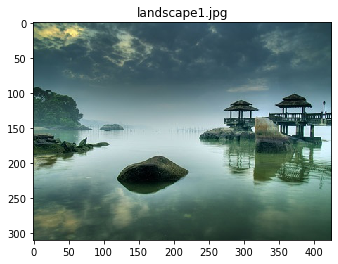

(310, 425, 3)


In [13]:
# Testing 2 b)
import time


# read in the image
landscape = plt.imread('landscape1.jpg')[:,:,:3]  # remove the transparency channel
plt.imshow(landscape)
plt.title("landscape1.jpg")
plt.show()
print(np.shape(landscape))


# upscale with separable filters
s = time.time()

I2, I3 = upscale(landscape, 3)

time_sep =  time.time() - s

#print(np.shape(I2))
#plt.imshow(I2)
#plt.show()

#print(I2[12:19, 12:19, 2])
#print(I3[12:19, 12:19, 2])

#plt.imshow(I3)
#plt.show()


# upscale with 2D convolution
s = time.time()
I5, I6 = upscale2(landscape, 3)
time_2dconv =  time.time() - s


# Upscaling using linear interpolation

In [14]:
# Question 2 b)


def Hat(x, d):
    '''
    1D "hat filter" (tent map)
    '''

    return np.where(x <= d, x/d, (2*d - x)/d)


def upscaleLinear(I, d):
    '''
    Upscales the rgb image I by factor d using linear interpolation
    '''
    
    
    # dimensions of image:
    L = np.shape(I)[0]
    W = np.shape(I)[1]
    
    # initialize new matrix with dimensions d times the size of the old image:
    bigImage = np.zeros((d*L,d*W, 3), dtype='int')
    
    # copy over values into their new positions:
    for i in range(L):
        for j in range(W):
            bigImage[d*i, d*j, :] = I[i,j,:]
    
    # create filter for upscaling:
    x = np.arange(0, 2*d + 1)
    h = Hat(x,d)
    
    # Since filter is separable, apply to all columns, then all rows:
    upscaledImage = np.zeros((d*L,d*W, 3))
    
    for channel in range(3):
        for row in range(3*L):
            upscaledImage[row, :, channel] = sp.signal.convolve(bigImage[row, :, channel], h, mode='same')
    
    for channel in range(3):
        for col in range(3*W):
            upscaledImage[:, col, channel] = sp.signal.convolve(upscaledImage[:, col, channel], h, mode='same')

    
    
    #upscaledImage = np.round(convolutionRGB(F,bigImage)).astype(int)
    
    return bigImage, np.round(upscaledImage).astype(int)


In [15]:

s = time.time()
I4 = upscaleLinear(landscape, 3)[1]
time_lin = time.time() - s

#plt.imshow(landscape)
#plt.show()

#plt.imshow(I4)
#plt.show()

#plt.imshow(landscape[100:200, 250:350, :])
#plt.show()
#plt.imshow(I4[300:600, 750:1050, :])
#plt.show()

# Comparing results

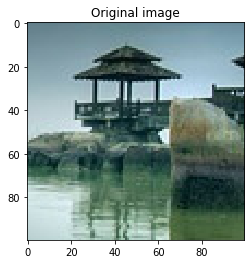

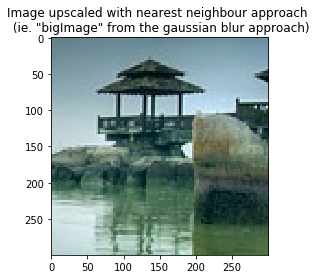

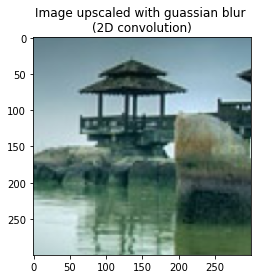

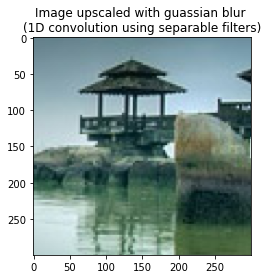

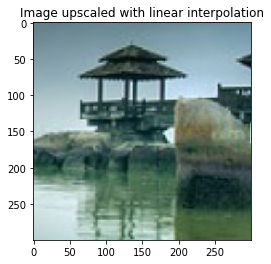

In [16]:
plt.imshow(landscape[100:200, 250:350, :])
plt.title("Original image")
plt.show()
plt.imshow(I2[300:600, 750:1050, :])
plt.title("Image upscaled with nearest neighbour approach \n (ie. \"bigImage\" from the gaussian blur approach)")
plt.show()
plt.imshow(I6[300:600, 750:1050, :])
plt.title("Image upscaled with guassian blur \n(2D convolution)")
plt.show()
plt.imshow(I3[300:600, 750:1050, :])
plt.title("Image upscaled with guassian blur \n(1D convolution using separable filters)")
plt.show()
plt.imshow(I4[300:600, 750:1050, :])
plt.title("Image upscaled with linear interpolation")
plt.show()


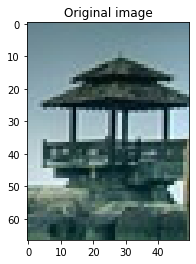

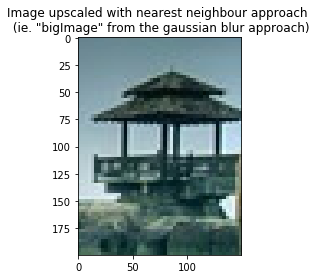

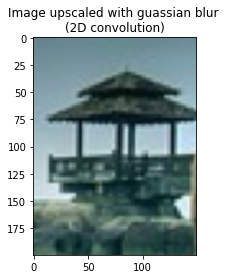

Time to compute: 19.754655361175537


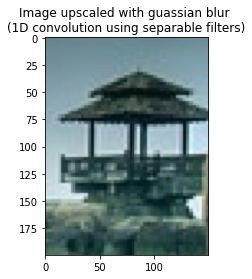

Time to compute: 1.6690394878387451


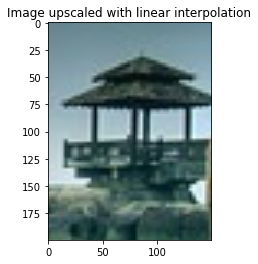

Time to compute: 0.5986466407775879


In [18]:
plt.imshow(landscape[100:167, 267:317, :])
plt.title("Original image")
plt.show()

plt.imshow(I2[300:500, 800:950, :])
plt.title("Image upscaled with nearest neighbour approach \n (ie. \"bigImage\" from the gaussian blur approach)")
plt.show()

plt.imshow(I6[300:500, 800:950, :])
plt.title("Image upscaled with guassian blur \n(2D convolution)")
plt.show()
print("Time to compute:", time_2dconv)

plt.imshow(I3[300:500, 800:950, :])
plt.title("Image upscaled with guassian blur \n(1D convolution using separable filters)")
plt.show()
print("Time to compute:", time_sep)

plt.imshow(I4[300:500, 800:950, :])
plt.title("Image upscaled with linear interpolation")
plt.show()
print("Time to compute:", time_lin)


The two methods are visually similar and linear interpolation was the fastest method (probably because it only assigns values to 1/9 of the pixels in the big image before the convolution, unlike the gaussian method, which assigns values to all the pixels